In [1]:
# Mount drive
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -q /content/drive/MyDrive/PBL6_Code/dataset.zip

# 1. Load data


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

import warnings

warnings.filterwarnings('ignore')

In [4]:
class DataGenerator():
    def __init__(self, batch_size, target_size=(256, 256)):
        self.batch_size = batch_size
        self.target_size = target_size

    def generate_data(self, subset, directory):

        print("Loading", subset, "...")

        shuffle = False
        if subset == 'train' or subset == 'validation':
            shuffle = True

        dataset = tf.keras.preprocessing.image_dataset_from_directory(
            directory,
            labels='inferred',
            label_mode='categorical',
            class_names=['0', '1'],
            color_mode='rgb',
            batch_size=self.batch_size,
            image_size=self.target_size,
            shuffle=shuffle,
            seed=42,
        )

        return dataset

In [5]:
def augmentation_layer(dataset):
    data_augmentation = tf.keras.Sequential(
        [
            tf.keras.layers.RandomFlip('horizontal'),
            tf.keras.layers.RandomContrast(0.2),
            tf.keras.layers.RandomBrightness(0.2),
        ]
    )
    dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
    return dataset

In [6]:
batch_size = 256
target_size = (256, 256)
data_gen = DataGenerator(batch_size, target_size)

train_set = data_gen.generate_data('train', '/content/dataset/train')
val_set = data_gen.generate_data('validation', '/content/dataset/validate')
test_set = data_gen.generate_data('test', '/content/dataset/test')

Loading train ...
Found 72574 files belonging to 2 classes.
Loading validation ...
Found 24190 files belonging to 2 classes.
Loading test ...
Found 24190 files belonging to 2 classes.


In [7]:
# get labels for evaluating step
labels = np.array([])
for x, y in test_set:
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

print(len(labels))

24190


In [8]:
train_set = augmentation_layer(train_set)

# 2. Define model/trainer/evaluator


## 2.1. Model class


In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.applications import MobileNetV3Large, EfficientNetB2

from tensorflow.keras.utils import plot_model
from IPython.display import Image


class CustomModels:
    """Custom Model Class"""

    def __init__(self, num_classes=1000, input_shape=(256, 256, 3), name='resnet'):
        self.num_classes = num_classes
        self.input_shape = input_shape
        self.name = name
        self.model = None

    def build(self):
        if "mobilenet" in self.name:
            base_model = MobileNetV3Large(include_top=False, weights='imagenet')

        elif "efficientnet" in self.name:
            base_model = EfficientNetB2(include_top=False, weights='imagenet')

        for layer in base_model.layers:
            layer.trainable = False

        inputs = Input(shape=self.input_shape)
        x = base_model(inputs, training=False)
        x = GlobalAveragePooling2D()(x)
        x = Dropout(0.1)(x)
        x = Dense(units=2048, activation='relu')(x)
        outputs = Dense(units=self.num_classes, activation='softmax')(x)
        model = Model(inputs=inputs, outputs=outputs, name=self.name)

        self.model = model
        return model

    def visualize(self):
        plot_model(self.model, show_shapes=True, to_file=self.name + '.png')
        image = Image(self.name + '.png')
        display(image)

    def summary(self):
        print(self.model.summary(show_trainable=True))

# 2.2 Define trainer


In [10]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import os


class Trainer:
    def __init__(
        self, model, loss, optimizer=Adam(learning_rate=0.001), metrics=['accuracy']
    ):
        self.model = model
        self.optimizer = optimizer
        self.loss = loss
        self.metrics = metrics
        self.history = None
        self.epochs = 0
        self.fine_tune_epochs = 0

    def compile(self):
        """
        Method to compile model with optimizer, loss and metrics
        """
        self.model.compile(
            optimizer=self.optimizer, loss=self.loss, metrics=self.metrics
        )

    def fit(self, train_set, val_set, batch_size, epochs, callbacks=[]):
        """
        Method to train model with dataset and return history
        """
        train_history = self.model.fit(
            train_set,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=val_set,
            callbacks=callbacks,
        )
        # history
        self.history = train_history.history
        self.epochs = len(train_history.history['val_loss'])

    def get_model_info(self):
        """Method to print all informations of model"""
        print("- Model name: ", self.model.name)
        print("- Number of layers: ", len(self.model.layers))
        print("- Base model name: ", self.model.layers[1].name)
        print("- Number of layers of base model: ", len(self.model.layers[1].layers))
        print("- Number of parameters: ", self.model.count_params())

    def fine_tune(
        self,
        train_set,
        val_set,
        batch_size,
        epochs,
        new_optimizer,
        callbacks=[],
        unfreeze_position=0,
    ):
        """
        Method to fine tune model with dataset and return history
        """
        # unfreeze layers
        for layer in self.model.layers[1].layers[unfreeze_position:]:
            if not isinstance(layer, layers.BatchNormalization):
                layer.trainable = True

        # recompile model
        self.model.compile(
            optimizer=new_optimizer, loss=self.loss, metrics=self.metrics
        )

        print("------------")
        print(
            f"Unfreezed from position {unfreeze_position} to {len(self.model.layers[1].layers) - 1}"
        )
        print(self.model.summary(show_trainable=True))

        output_file = "/content/finetune_layer_info.txt"
        with open(output_file, "w") as f:
            for i, layer in enumerate(self.model.layers[1].layers):
                f.write(f"{i} {layer.name} {layer.trainable}\n")
        print("------------")
        # print total trainable param of basemodel
        total_trainable_param = 0
        for layer in self.model.layers[1].layers:
            if layer.trainable:
                total_trainable_param += layer.count_params()
        print(f"Total trainable param of base model: {total_trainable_param}")

        # fine tune model
        fine_tune_history = self.model.fit(
            train_set,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=val_set,
            callbacks=callbacks,
        )

        # add fine tune history to train history
        self.history['accuracy'] += fine_tune_history.history['accuracy']
        self.history['loss'] += fine_tune_history.history['loss']
        self.history['val_accuracy'] += fine_tune_history.history['val_accuracy']
        self.history['val_loss'] += fine_tune_history.history['val_loss']

        epochs = len(fine_tune_history.history['val_loss'])
        self.epochs += epochs
        self.fine_tune_epochs += epochs

    def plot_history(self):
        """
        Method to plot model training history
        """

        fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

        axes[0].plot(self.history['accuracy'])
        axes[0].plot(self.history['val_accuracy'])
        # draw line at fine tune position
        if self.fine_tune_epochs > 0:
            axes[0].axvline(
                x=self.epochs - self.fine_tune_epochs, color='red', linestyle='--'
            )

        axes[0].set_ylabel('Accuracy')

        axes[1].plot(self.history['loss'])
        axes[1].plot(self.history['val_loss'])

        # draw line at fine tune position
        if self.fine_tune_epochs > 0:
            axes[1].axvline(
                x=self.epochs - self.fine_tune_epochs, color='red', linestyle='--'
            )

        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Loss')

        fig.suptitle('Model performance during training')
        axes[0].legend(('Train accuracy', 'Validation accuracy'))
        axes[1].legend(('Train loss', 'Validation loss'))

    def save_model(self, path='/content/drive/MyDrive/new_saved_model'):
        """
        Method to save model after training
        """
        save_path = os.path.join(path, f'{self.model.name}.h5')
        self.model.save(save_path)
        return save_path

# 2.3 Define evaluator


In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report


class Evaluator:

    def __init__(self, model, test_set, y_true):
        self.model = model

        self.test_loss, self.test_acc = self.model.evaluate(
            test_set, verbose=1)

        y_pred = self.model.predict(test_set)
        y_pred = np.argmax(y_pred, axis=1)

        self.cm = confusion_matrix(y_true, y_pred)

        self.report = classification_report(y_true, y_pred)

    def evaluate(self):
        """
        Method to evaluate model and return loss and accuracy
        """
        return self.test_loss, self.test_acc

    def confusion_matrix(self):
        """
        Method to plot confusion matrix
        """
        sns.heatmap(self.cm, annot=True, fmt="d")
        plt.show()

    def classification_report(self):
        """
        Method to print classification report on test set
        """
        print(self.report)

# 3. Train/Test model


## 3.1. Create model


31790344/31790344 [==============================] - 2s 0us/step


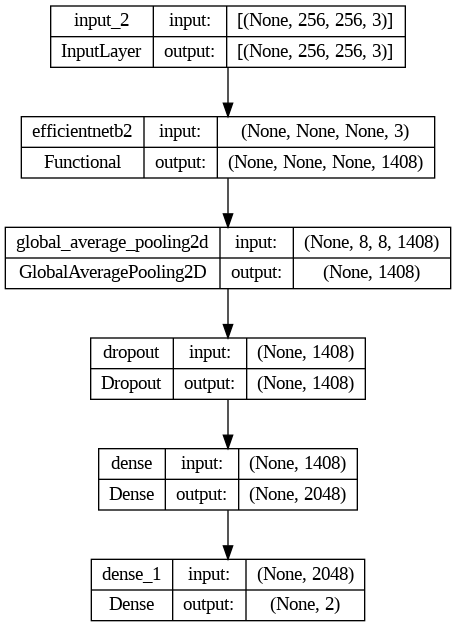

In [12]:
custom_model = CustomModels(
    num_classes=2, input_shape=(256, 256, 3), name='efficientnet_new_50_12'
)
custom_model.build()
custom_model.visualize()

In [13]:
custom_model.summary()

Model: "efficientnet_new_50_12"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         Y          
                                                                            
 efficientnetb2 (Functional  (None, None, None, 1408   7768569   Y          
 )                           )                                              
                                                                            
 global_average_pooling2d (  (None, 1408)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dropout (Dropout)           (None, 1408)              0         Y          
                                                                            
 dense (Dense)               (None, 2048)   

## 3.2. Train model


In [14]:
# Define hyperparameters for model trainer
import math
import os

epochs = 30
batch_size = 256

metrics = ['accuracy']
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

initial_learning_rate = 0.01
optimizer = tf.keras.optimizers.Adam(initial_learning_rate)

def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 5.0
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch / epochs_drop))

checkpoint_filepath = os.path.join(
    '/content/drive/MyDrive/checkpoints',
    custom_model.model.name,
    "training",
    "{epoch:03d}-{val_loss:.4f}.h5",
)

os.makedirs(checkpoint_filepath, exist_ok=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', mode='min', verbose=1, patience=10
)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr_step_decay, verbose=1)

In [15]:
# Compile and train model
trainer = Trainer(custom_model.model, loss, optimizer, metrics)

# Compile model
trainer.compile()

# Train model
trainer.fit(train_set=train_set, val_set=val_set, batch_size=batch_size, epochs=epochs, callbacks=[lr_schedule, early_stopping, checkpoint])


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/30
284/284 [==============================] - 248s 806ms/step - loss: 0.4828 - accuracy: 0.7999 - val_loss: 0.3884 - val_accuracy: 0.8252 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/30
284/284 [==============================] - 230s 806ms/step - loss: 0.3909 - accuracy: 0.8273 - val_loss: 0.3949 - val_accuracy: 0.8258 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.01.
Epoch 3/30
284/284 [==============================] - 226s 791ms/step - loss: 0.3719 - accuracy: 0.8351 - val_loss: 0.3702 - val_accuracy: 0.8387 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.01.
Epoch 4/30
284/284 [==============================] - 225s 789ms/step - loss: 0.3547 - accuracy: 0.8441 - val_loss: 0.3708 - val_accuracy: 0.8404 - lr: 0.0100

Epoch 5: LearningRateScheduler setting learning rate to 0.01.
Epoch 5/30
284/284 [=============================

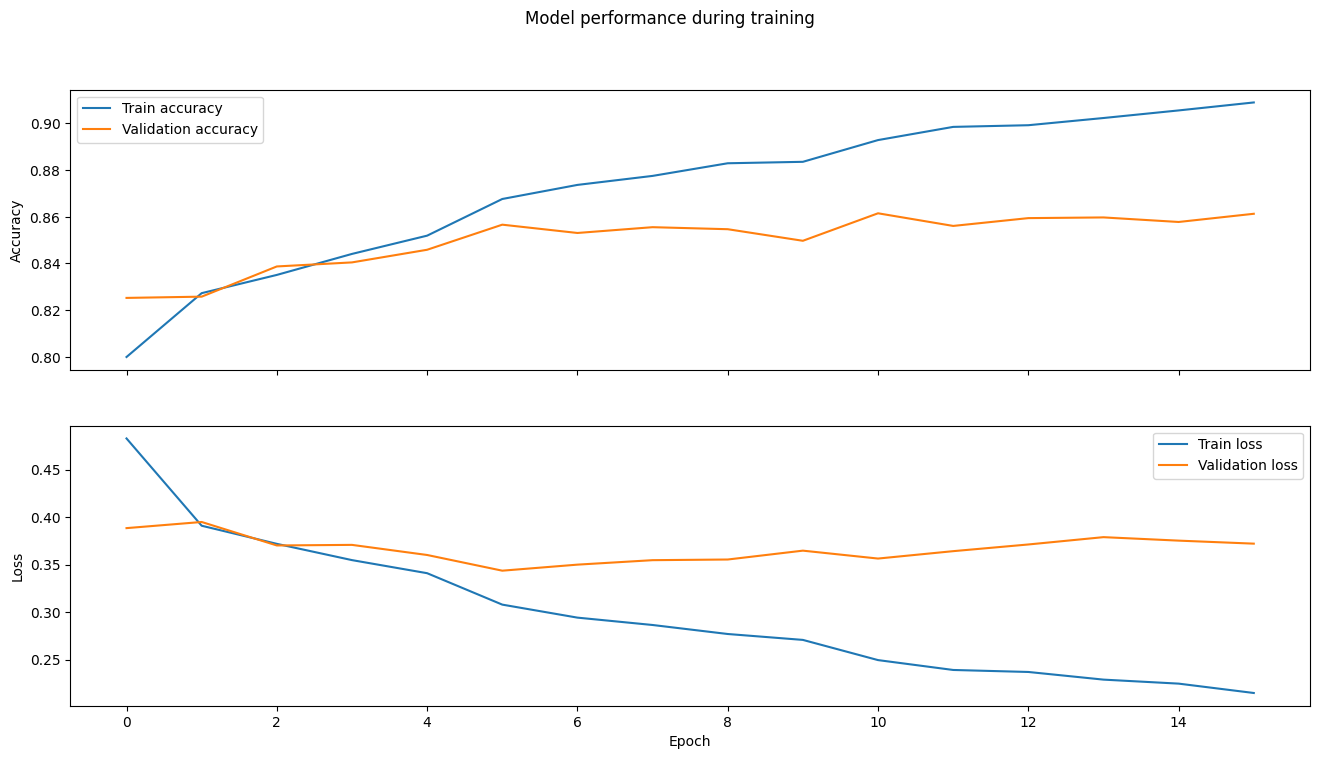

In [16]:
trainer.plot_history()

In [17]:
evaluate = Evaluator(trainer.model, test_set, labels)

95/95 [==============================] - 29s 286ms/step


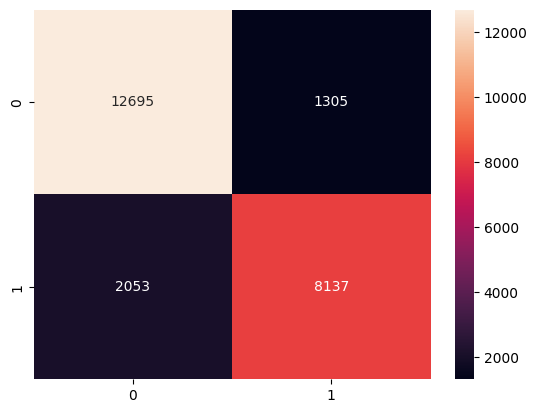

In [18]:
evaluate.confusion_matrix()

In [19]:
evaluate.classification_report()

              precision    recall  f1-score   support

         0.0       0.86      0.91      0.88     14000
         1.0       0.86      0.80      0.83     10190

    accuracy                           0.86     24190
   macro avg       0.86      0.85      0.86     24190
weighted avg       0.86      0.86      0.86     24190



## 3.3. Fine-tuning model


In [20]:
trainer.get_model_info()

- Model name:  efficientnet_new_50_12
- Number of layers:  6
- Base model name:  efficientnetb2
- Number of layers of base model:  340
- Number of parameters:  10658299


In [21]:
# Define hyperparameters for finetuning
import os
import math

epochs = 12
batch_size = 256


metrics = ['accuracy']
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

initial_learning_rate = 0.001
new_optimizer = tf.keras.optimizers.Adam(initial_learning_rate)

def lr_step_decay_2(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 3.0
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch / epochs_drop))

checkpoint_filepath = os.path.join(
    '/content/drive/MyDrive/checkpoints',
    custom_model.model.name,
    "finetuning",
    "{epoch:03d}-{val_loss:.4f}.h5",

)

os.makedirs(checkpoint_filepath, exist_ok=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', mode='min', verbose=1, patience=6
)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr_step_decay_2, verbose=1)

In [22]:
# Fine tune model
trainer.fine_tune(train_set=train_set, val_set=val_set, batch_size=batch_size, epochs=epochs, new_optimizer= new_optimizer,
                  callbacks=[lr_schedule, early_stopping, checkpoint], unfreeze_position=300)

------------
Unfreezed from position 300 to 339
Model: "efficientnet_new_50_12"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         Y          
                                                                            
 efficientnetb2 (Functional  (None, None, None, 1408   7768569   Y          
 )                           )                                              
                                                                            
 global_average_pooling2d (  (None, 1408)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dropout (Dropout)           (None, 1408)              0         Y          
                                                                         

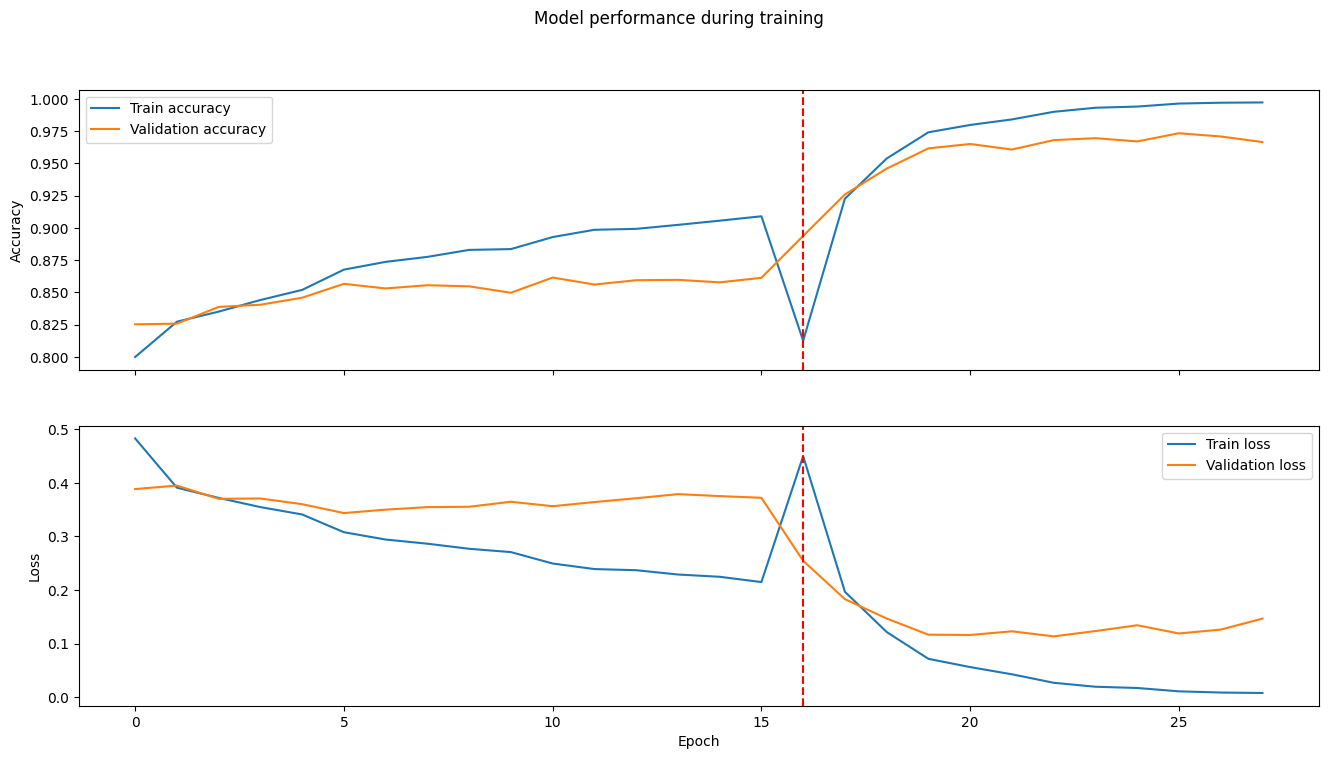

In [23]:
trainer.plot_history()

## 3.4. Evaluate model


In [24]:
evaluate = Evaluator(trainer.model, test_set, labels)

95/95 [==============================] - 29s 286ms/step


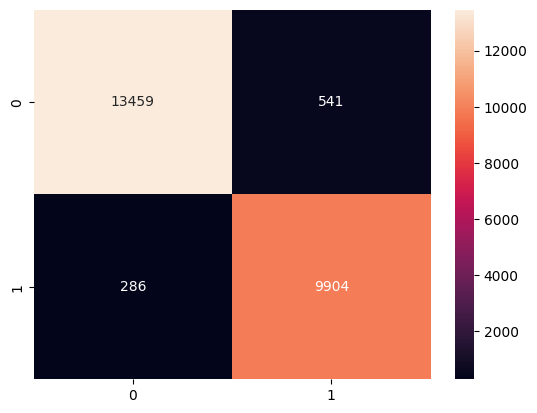

In [25]:
evaluate.confusion_matrix()

In [26]:
evaluate.classification_report()

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97     14000
         1.0       0.95      0.97      0.96     10190

    accuracy                           0.97     24190
   macro avg       0.96      0.97      0.97     24190
weighted avg       0.97      0.97      0.97     24190



## 3.5. Save model


In [27]:
trainer.save_model()

'/content/drive/MyDrive/new_saved_model/efficientnet_new_50_12.h5'

# 4. Inference


In [28]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
from keras.models import load_model


def preprocess_image(image_path, target_size=(256, 256)):
    img = load_img(image_path, target_size=target_size)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    return x


def predict_image(image_data, model_path):
    model = load_model(model_path, compile=False)
    prediction = model.predict(image_data)
    print(prediction)
    predicted_class = np.argmax(prediction)

    if predicted_class == 0:
        predicted_label = "real"
    else:
        predicted_label = "fake"

    return predicted_label

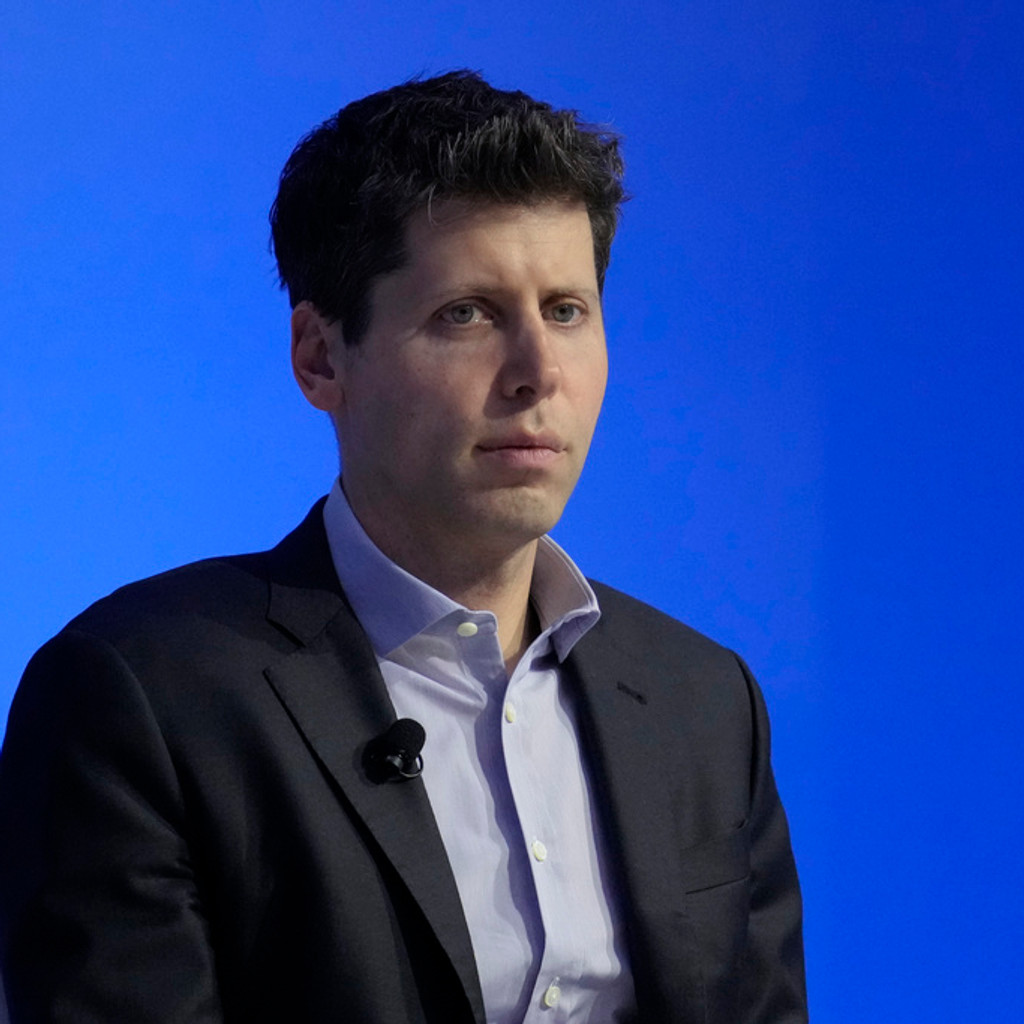

In [33]:
# download a fake image to test
from IPython.display import Image
import requests

URL = "https://cbsaustin.com/resources/media/8b2d4079-8b82-465b-9514-8da9af8d5b49-full1x1_AP23326229180956.jpg"
response = requests.get(URL)

image_name = 'real.png'

with open(image_name, "wb") as f:
    f.write(response.content)

image = Image(image_name)
display(image)

In [34]:
# Preprocess image
image_name = 'real.png'
image = preprocess_image(image_name)
model_path = '/content/drive/MyDrive/new_saved_model/efficientnet_new_50_12.h5'
predicted_class = predict_image(image, model_path)
print("Predicted class:", predicted_class)

1/1 [==============================] - 2s 2s/step
[[1.0000000e+00 1.4003637e-13]]
Predicted class: real


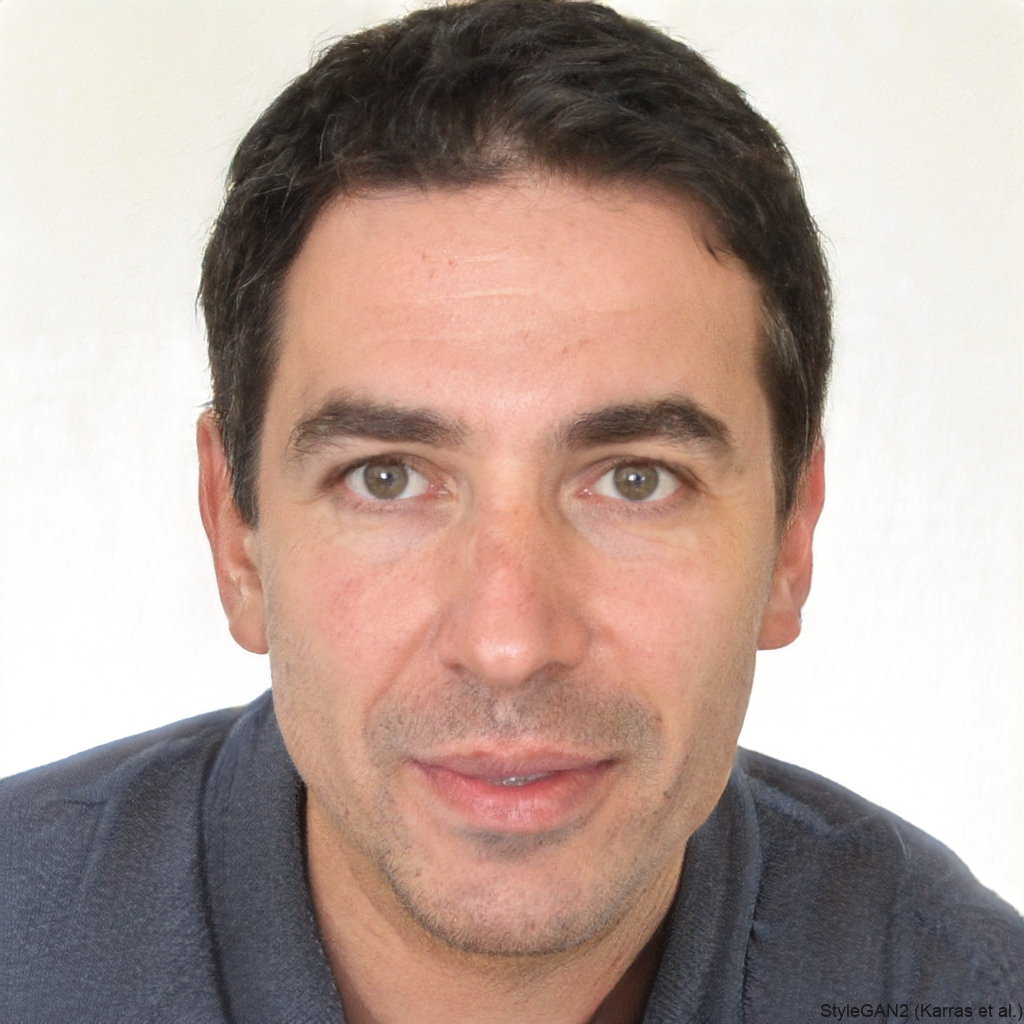

In [35]:
# download a fake image to test
from IPython.display import Image
import requests
URL = "https://thispersondoesnotexist.com/"
response = requests.get(URL)

image_name = 'fake.png'

with open(image_name, "wb") as f:
    f.write(response.content)

image = Image(image_name)
display(image)

In [36]:
# Preprocess image
image_name = 'fake.png'
image = preprocess_image(image_name)
model_path = '/content/drive/MyDrive/saved_model/efficientnet_augu_20_50.h5'
predicted_class = predict_image(image, model_path)
print("Predicted class:", predicted_class)

1/1 [==============================] - 2s 2s/step
[[0.02050331 0.9794967 ]]
Predicted class: fake
